In [2]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np

In [18]:
true_params = dict(
    fD = ss.skewnorm(a=-2.35217102,
                    loc=-1.55031695,
                    scale=0.77525406),
    fN = ss.skewnorm(a=-0.93037852,
                    loc=0.12707752,
                    scale=0.39826615),
    W = np.array([[0.98189558, 0.01810442],
                [0.03432592, 0.96567408],]),
    prior = 0.12)


In [19]:
from copy import deepcopy
def sample_data(params, sample_sizes, label_noise=0.0):
    fD = params['fD']
    fN = params['fN']
    wPathogenic, wBenign = params['W']
    prior = params['prior']
    nDP, nNP, nDB, nNB = np.round(sample_sizes[-1] * np.array([prior * wPathogenic[0],
                                    prior * wPathogenic[1],
                                    (1-prior) * wBenign[0],
                                    (1-prior) * wBenign[1]])).astype(int)
    cleanPathogenicityLabels = [np.ones(sample_sizes[0],dtype=int),
                                            np.zeros(sample_sizes[1],dtype=int),
                                            np.ones(nDP + nNP,dtype=int),
                                            np.zeros(nDB + nNB,dtype=int)]
    pathogenicityLabels = deepcopy(cleanPathogenicityLabels)
    if label_noise > 0:
        pathogenicityLabels[0] = np.random.binomial(1, 1-label_noise, sample_sizes[0])
        pathogenicityLabels[1] = np.random.binomial(1, label_noise, sample_sizes[1])
    
    sampleNumbers = np.concatenate([1 - pathogenicityLabels[0],
                                    1 - pathogenicityLabels[1],
                                    np.ones(sample_sizes[2],dtype=int)*2])
    pathogenicityLabels = np.concatenate(pathogenicityLabels)
    observations = np.concatenate([
        fD.rvs(np.round(sample_sizes[0] * wPathogenic[0]).astype(int)),
        fN.rvs(np.round(sample_sizes[0] * wPathogenic[1]).astype(int)),
        fD.rvs(np.round(sample_sizes[1] * wBenign[0]).astype(int)),
        fN.rvs(np.round(sample_sizes[1] * wBenign[1]).astype(int)),
        fD.rvs(nDP), fN.rvs(nNP), fD.rvs(nDB), fN.rvs(nNB)])
    sampleIndicators = np.zeros((len(observations), len(sample_sizes)),dtype=int)
    sampleIndicators[np.arange(len(observations)), sampleNumbers] = 1
    return observations, sampleIndicators, pathogenicityLabels, np.concatenate(cleanPathogenicityLabels)


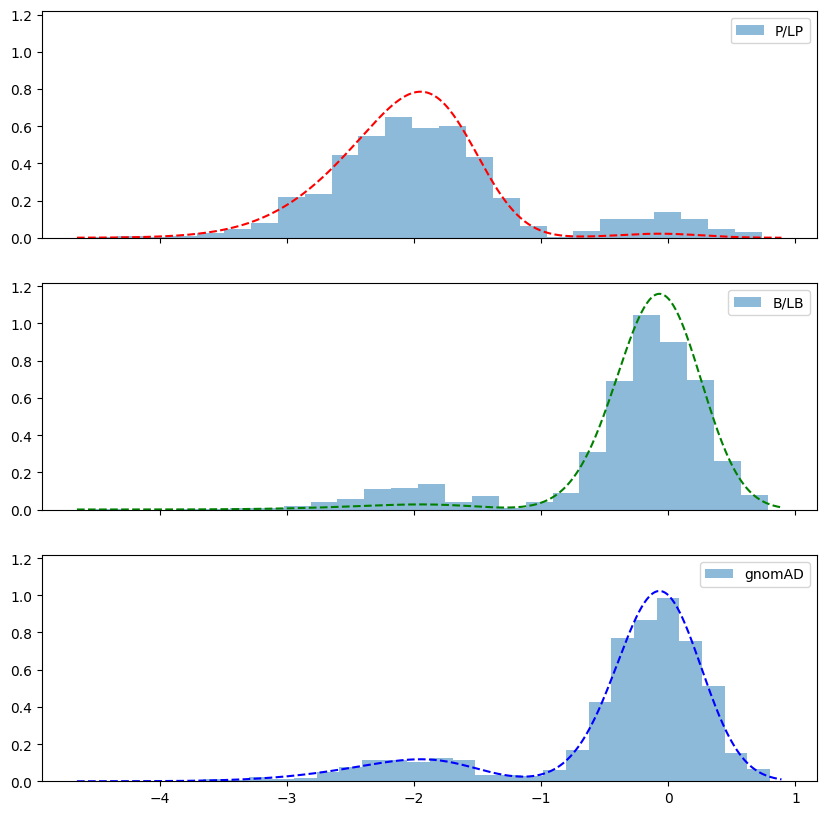

In [31]:
X,S,YTilde, Y = sample_data(true_params, [1000,1000,1000],label_noise=0.1)
rng = np.arange(min(X)-.1,max(X)+.1,0.01)
fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True,sharey=True)
for sampleNum,sampleName in enumerate(["P/LP",'B/LB','gnomAD']):
    ax[sampleNum].hist(X[S[:,sampleNum]==1],
                        bins=25,
                        alpha=0.5,
                        label=sampleName,
                        density=True)
    ax[sampleNum].legend()
W = true_params['W']
fD = true_params['fD']
fN = true_params['fN']
prior = true_params['prior']
ax[0].plot(rng,W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng),linestyle='--',color='red',label='true')
ax[1].plot(rng,W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng),linestyle='--',color='green',label='true')
ax[2].plot(rng,prior*(W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng)) + \
                (1-prior)*(W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng)),linestyle='--',color='blue',label='true')
    

In [32]:
from mave_calibration import main
from joblib import Parallel, delayed
import sys
sys.path.append("/home/dzeiberg")
from mave_results.utils import threshold_utils

In [33]:
def runSingleFit(NFITS = 100):
    fit_results = Parallel(n_jobs=NFITS,verbose=10)(delayed(main.runFitIteration)(X,S) \
                                                                        for i in range(NFITS))
    fit_results = sorted(fit_results,key=lambda tup: tup[1],reverse=True)
    return fit_results[0][0]

In [34]:
fit_i = runSingleFit()

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
EM Iteration:   3%|▎         | 339/10000 [00:06<02:08, 75.32it/s, likelihood=-6.444016][Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:    6.7s remaining:    0.9s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:   14.3s finished                 


In [35]:
W = fit_i['weights']
fD = ss.skewnorm(*fit_i['component_params'][0])
fN = ss.skewnorm(*fit_i['component_params'][1])
prior = threshold_utils.prior_from_weights(fit_i['weights'])
ax[0].plot(rng,W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng),linestyle='-',color='red',label='estimated')
ax[1].plot(rng,W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng),linestyle='-',color='green',label='estimated')
ax[2].plot(rng,prior*(W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng)) + \
                (1-prior)*(W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng)),linestyle='-',color='blue',label='estimated')
[ax[i].legend() for i in range(3)]
    

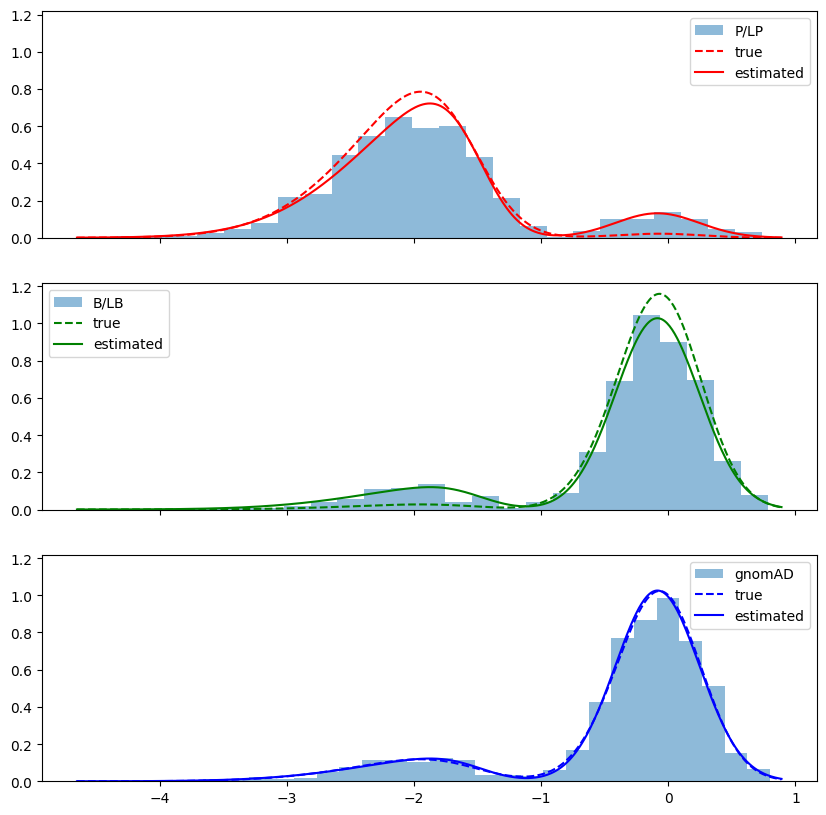

In [36]:
fig

In [ ]:
threshold_utils.